# Real-time $R_t$ computation on Italian COVID-19 data, by Stefano Terna$^1$

$^1$ PhD String Theory, [tomorrowdata.io](https://tomorrowdata.io) CEO

## Citations

1. Real Time Bayesian Estimation of the Epidemic Potential of Emerging Infectious Diseases, Luı´s M. A. Bettencourt, Ruy M. Ribeiro, [paper](https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0002185&type=printable)
2. A New Framework and Software to Estimate Time-Varying Reproduction Numbers During Epidemics, Anne Cori, Neil M. Ferguson, Christophe Fraser, and Simon Cauchemez, [paper and supplementary data](https://academic.oup.com/aje/article/178/9/1505/89262)
3. Numero di riproduzione netto al tempo t, [Wikipedia](https://it.wikipedia.org/wiki/Numero_di_riproduzione_di_base#Numero_di_riproduzione_netto_al_tempo_t) 
4. FAQ sul calcolo del Rt, Istituto Superiore di Sanità, [link](https://www.iss.it/primo-piano/-/asset_publisher/o4oGR9qmvUz9/content/faq-sul-calcolo-del-rt)
5. Lockdown Can’t Last Forever. Here’s How to Lift It, Gabriel Leung, University of Hong Kong, [New York Times](https://www.nytimes.com/2020/04/06/opinion/coronavirus-end-social-distancing.html) 
6. Azienda sanitaria dell’Alto Adige, [Risultati](https://coronatest.sabes.it/it/muni) dello Screening a livello provinciale per il contenimento del Coronavirus
7. Task force COVID-19 del Dipartimento Malattie Infettive e Servizio di Informatica, Istituto Superiore di Sanità. Epidemia COVID-19, Aggiornamento nazionale: 18 novembre 2020
8. Tikhonov regularization, [Wikipedia](https://en.wikipedia.org/wiki/Tikhonov_regularization)
9. Task force COVID-19 del Dipartimento Malattie Infettive e Servizio di Informatica, Istituto Superiore di Sanità. Epidemia COVID-19, Aggiornamento nazionale: 18 agosto 2020
10. Dati COVID-19 Italia, Protezione Civile, [github](https://github.com/pcm-dpc/COVID-19)
11. "Monitoraggio settimanale - Ministero della Salute" check [here](http://www.salute.gov.it/portale/nuovocoronavirus/archivioNotizieNuovoCoronavirus.jsp?lingua=italiano&tipo=Report+settimanale+Covid-19&btnCerca=cerca) for new weekly updates.
12. "Monitoraggio settimale" by Istituto Superiore di Sanità, detailed reports, [here](https://www.iss.it/monitoraggio-settimanale)

In [1]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('../')

In [2]:
import os
import locale
locale.setlocale(locale.LC_TIME, "it_IT.UTF8")
from datetime import datetime, timedelta
from matplotlib import pyplot as plt, dates as mdates
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import mean_squared_error
import pymc3 as pm

from covid19_pytoolbox.settings import BASE_DATA_PATH, BASE_IMAGES_PATH
from covid19_pytoolbox import plotting
from covid19_pytoolbox.italy.data import ISS
from covid19_pytoolbox.italy.data import DPC
from covid19_pytoolbox.smoothing.seasonalRSVD.LogRSVD import LogSeasonalRegularizer
from covid19_pytoolbox.smoothing.tikhonovreg import TikhonovRegularization
from covid19_pytoolbox.modeling.datarevision.seasonal import draw_expanded_series, smooth_and_drop
from covid19_pytoolbox.modeling.Rt.bayesian import MCMC_sample
from covid19_pytoolbox.utils import smape, padnan, RSVD_smooth_data_generic

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
date_ = os.environ.get("REF_DATE")
if date_ is None:
    date_ = "2021-11-28"
print(date_)

2021-11-28


In [4]:
pastdays='002'

## Rt gamma parameters:

In [5]:
alpha = 1.87
beta = 0.28

ALPHA=100.

## Load DPC data, smooth them and compute naive Rt

In [6]:
DPC_data = DPC.load_daily_cases_from_github()
TIMESTEPS, FIRST_CASI_SOSP_DIAGNOSTICO = DPC.preprocess(DPC_data)
DPC.compute_first_diffs(DPC_data)
regularizer = TikhonovRegularization(timesteps=TIMESTEPS, alpha=ALPHA)
DPC.tikhonov_smooth_differentiate(DPC_data, regularizer)
DPC.bulk_compute_naive_Rt(DPC_data, alpha=alpha, beta = beta)

{   'deceduti_giornalieri': 'deceduti',
    'dimessi_guariti_giornalieri': 'dimessi_guariti',
    'nuovi_casi_da_screening': 'casi_da_screening',
    'nuovi_casi_da_sospetto_diagnostico': 'casi_da_sospetto_diagnostico',
    'nuovi_ospedalizzati': 'hospitalized_cumulative',
    'tamponi_giornalieri': 'tamponi'}
{   'deceduti_giornalieri_smoothed': 'deceduti',
    'dimessi_guariti_giornalieri_smoothed': 'dimessi_guariti',
    'nuovi_casi_da_screening_smoothed': 'casi_da_screening',
    'nuovi_casi_da_sospetto_diagnostico_smoothed': 'casi_da_sospetto_diagnostico',
    'nuovi_ospedalizzati_smoothed': 'hospitalized_cumulative',
    'nuovi_positivi_smoothed': 'totale_casi',
    'tamponi_giornalieri_smoothed': 'tamponi'}
tamponi_giornalieri_smoothed - TIC R2: 0.9999979522280552
dimessi_guariti_giornalieri_smoothed - TIC R2: 0.9999979326070891
deceduti_giornalieri_smoothed - TIC R2: 0.9999987401842014
nuovi_positivi_smoothed - TIC R2: 0.9999989048004495
nuovi_casi_da_sospetto_diagnostico_smoot

# Use RSVD: Regularized Singular Value Decomposition

RSVD allows to detect the seasonal component of the signal.

In the case of DPC `nuovi_positivi` we have a **weekly seasonality**, hence `season_period = 7`

RSVD has been proposed by Wei Lin, Jianhua Huang (Texas A&M University), Tucker Mcelroy (U.S. Census Bureau), in this [paper](https://www.researchgate.net/publication/327256122_Time_Series_Seasonal_Adjustment_Using_Regularized_Singular_Value_Decomposition)

It essentially casts the signal vector into a matrix whose columns are the seasons and the rows are the repetitive periods of a complete series of seasons. In our case the matrix shape will be `(~len(signal) / 7, 7)`.
Singular Value Decomposition is applied to the matrix so that singular values represent the seasonal component of the signal. Each (7 in our case) seasonal component is regularized via Tikhonov, following the hypotheis that each season component, period after period, must change smoothly. The Tikhonov regularization paramether is fitted via "leave one out cross validation".

The advantage of this method with respect to the SARIMA approach is that **we don't need to take moving averages**, and we don't need to tune any metaparameter of the model.

We wrote the python porting of the original R code.
The python porting is available from the following namespace:
```
import covid19_pytoolbox.smoothing.seasonalRSVD
```

The following features have been added to the original work:
- RSVD is applied by means of two different classes:
  - `SeasonalRegularizer` applies RSVD to the plain data
  - `LogSeasonalRegularizer` applies RSVD on the logarithm of the data to remove exponential trends; the inverse functions are correctly applied before returning the outputs, to remove the effects of taking the logarithm on the original signal
- both classes accept a `difference_degree` parameters; if greater then 0, the `n-th = difference_degree` difference is taken on the original signal prior to apply RSVD; this is helpful to remove non-stationarity in the original data
- the `adfuller` test can be performed on the input data to check (manually) if any non-stationary component is present
- the Tikhonov regularized trend is extracted from the deseasoned signal
- residuals are computed as differences between the deseasoned signal and the smoothed trend; relative residuals are also computed by the `LogSeasonalRegularizer`
- the signal is left truncated to obtain the RSVD matrix; before returning, the outputs are padded with `np.nan` to the left, to rebuild the original vector shape


In [7]:
DPC.RSVD_smooth_data(DPC_data, alpha=alpha, beta=beta, difference_degree=2, trend_alpha=ALPHA)

[   'nuovi_positivi',
    'tamponi_giornalieri',
    'nuovi_ospedalizzati',
    'deceduti_giornalieri',
    'ingressi_terapia_intensiva']
nuovi_positivi_deseason
info_cri:  -2.484762817039692
info_cri:  -2.2419840465720675
TIC R2: 0.994201457035933
patterns: 1
(   -7.671896917069506,
    1.5855216454769482e-11,
    20,
    621,
    {   '1%': -3.440924132966757,
        '10%': -2.5692545786625383,
        '5%': -2.866205413627313},
    -470.9171305189377)
new columns generated:
[   'nuovi_positivi_deseason',
    'nuovi_positivi_deseason_seasonality',
    'nuovi_positivi_deseason_smoothed',
    'nuovi_positivi_deseason_residuals',
    'nuovi_positivi_deseason_relative_residuals',
    'nuovi_positivi_deseason_smoothed_Rt']
tamponi_giornalieri_deseason
info_cri:  -2.78896236408575
info_cri:  -0.44159362469210484
TIC R2: 0.9685030342099793
patterns: 1
(   -9.786628766680833,
    6.517406299015129e-17,
    20,
    621,
    {   '1%': -3.440924132966757,
        '10%': -2.5692545786625383,
   

## Plotting the signal after applying RSVD

- the blue line is the original signal
- the violet line represent the oscillating seasonal component
- the orange line is the deseasoned signal
  - we can see how the orange line is much less oscillating with respect to the blue one, as RSVD succeded in removing the seasonal component
- the red line represents the smoothed trend of the deseasoned signal

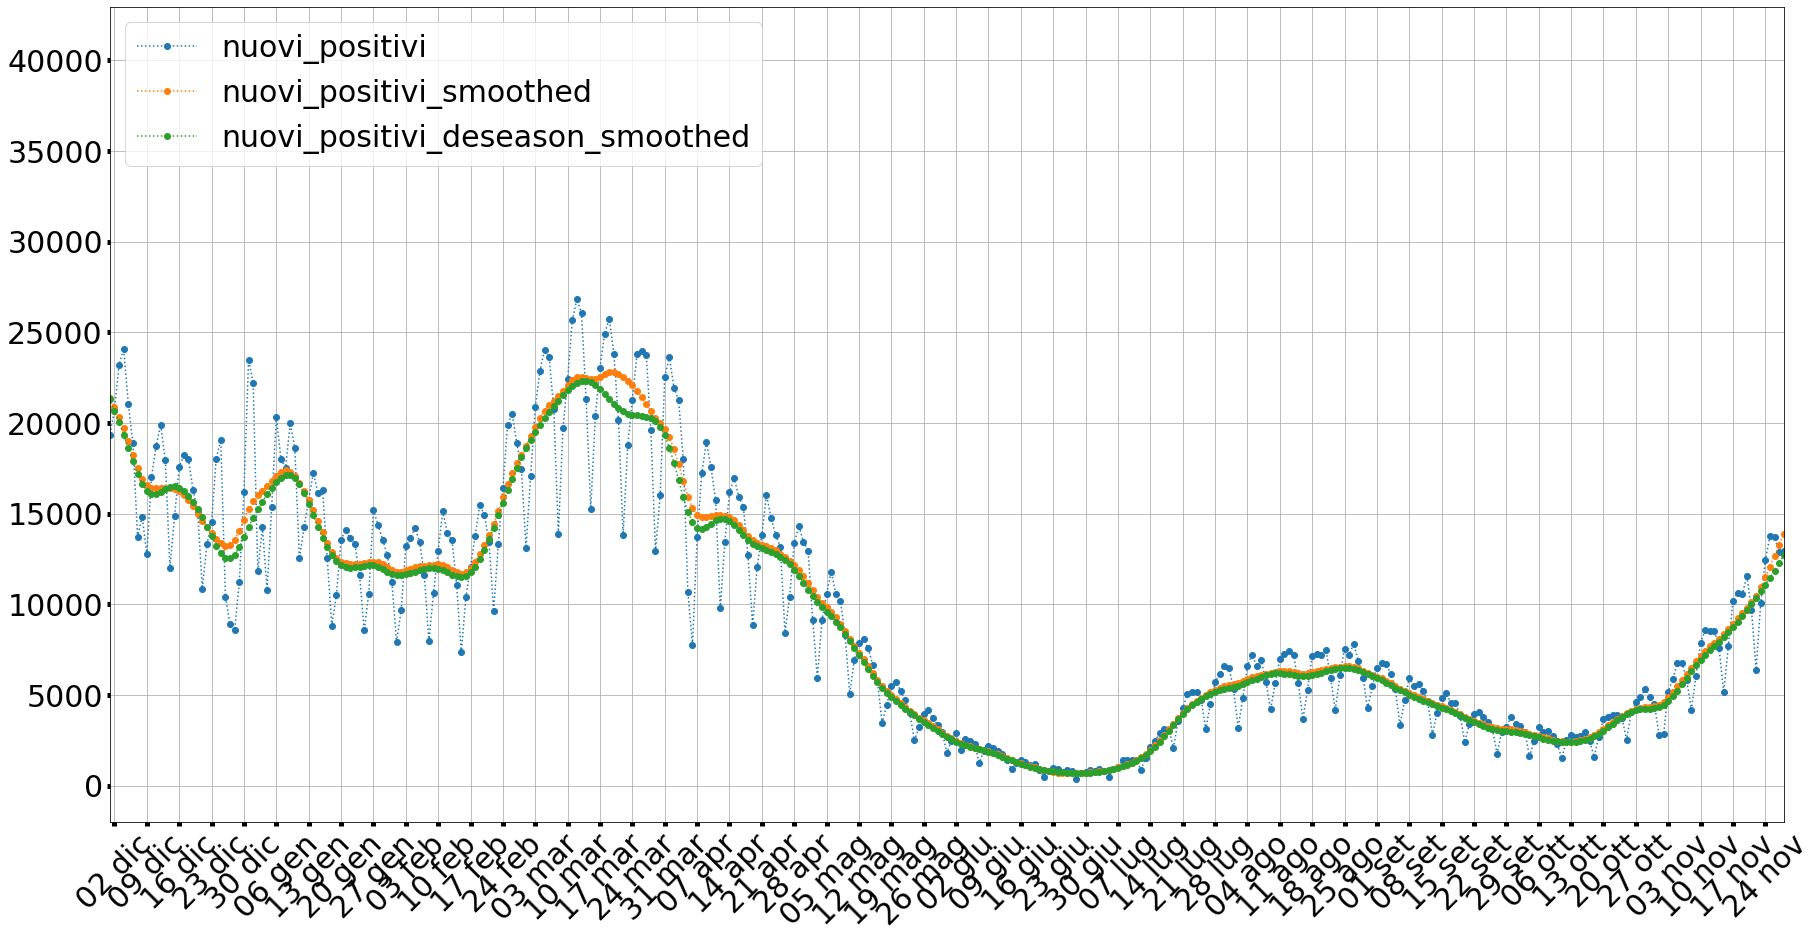

In [8]:
plotting.plot_series(
    df=DPC_data,
    yfields=[
        'nuovi_positivi', 
        'nuovi_positivi_smoothed',
        'nuovi_positivi_deseason_smoothed'
    ],
    #xlim=(datetime(2020,7,25), datetime(2020,10,1)),#DPC_data.data.max()),
    #ylim=(-1000,1000),
    xlim=(datetime(2020,12,1), DPC_data.data.max()),
    #ylim=(-10000,40000),
    legend_loc="upper left"
)

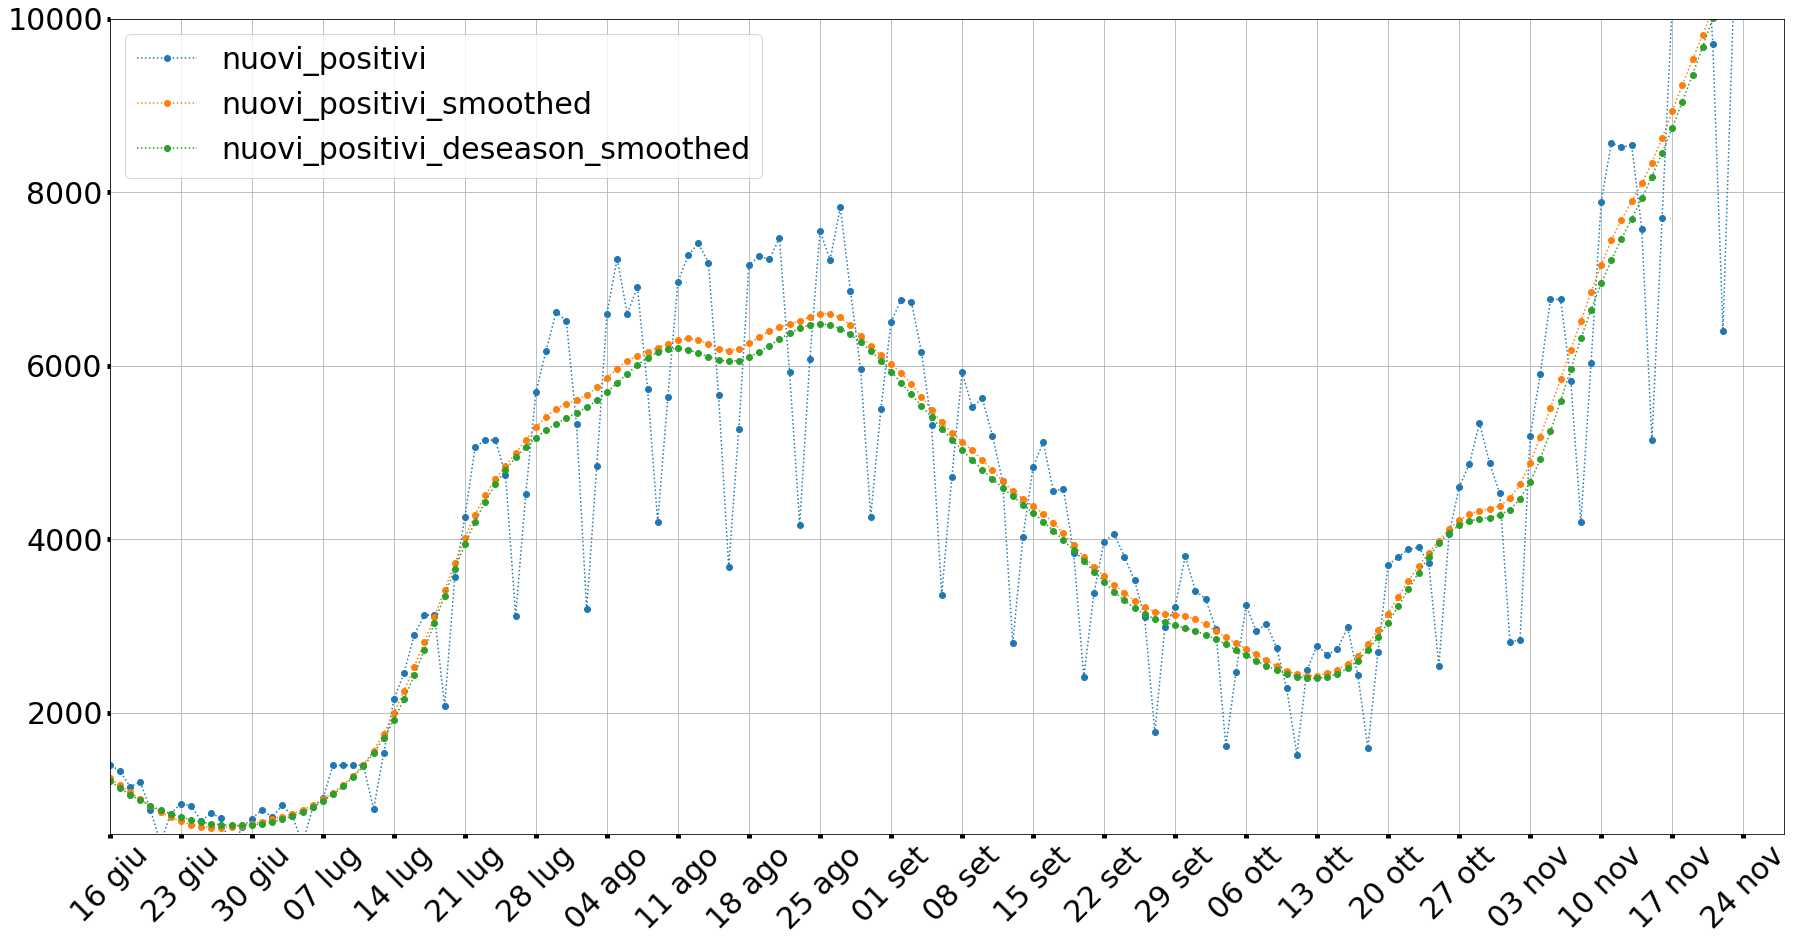

In [9]:
plotting.plot_series(
    df=DPC_data,
    yfields=[
        'nuovi_positivi', 
        'nuovi_positivi_smoothed',
        'nuovi_positivi_deseason_smoothed'
    ],
    #xlim=(datetime(2020,7,25), datetime(2020,10,1)),#DPC_data.data.max()),
    ylim=(600,10000),
    xlim=(datetime(2021,6,16), DPC_data.data.max()),
    #ylim=(-10000,40000),
    legend_loc="upper left"
)

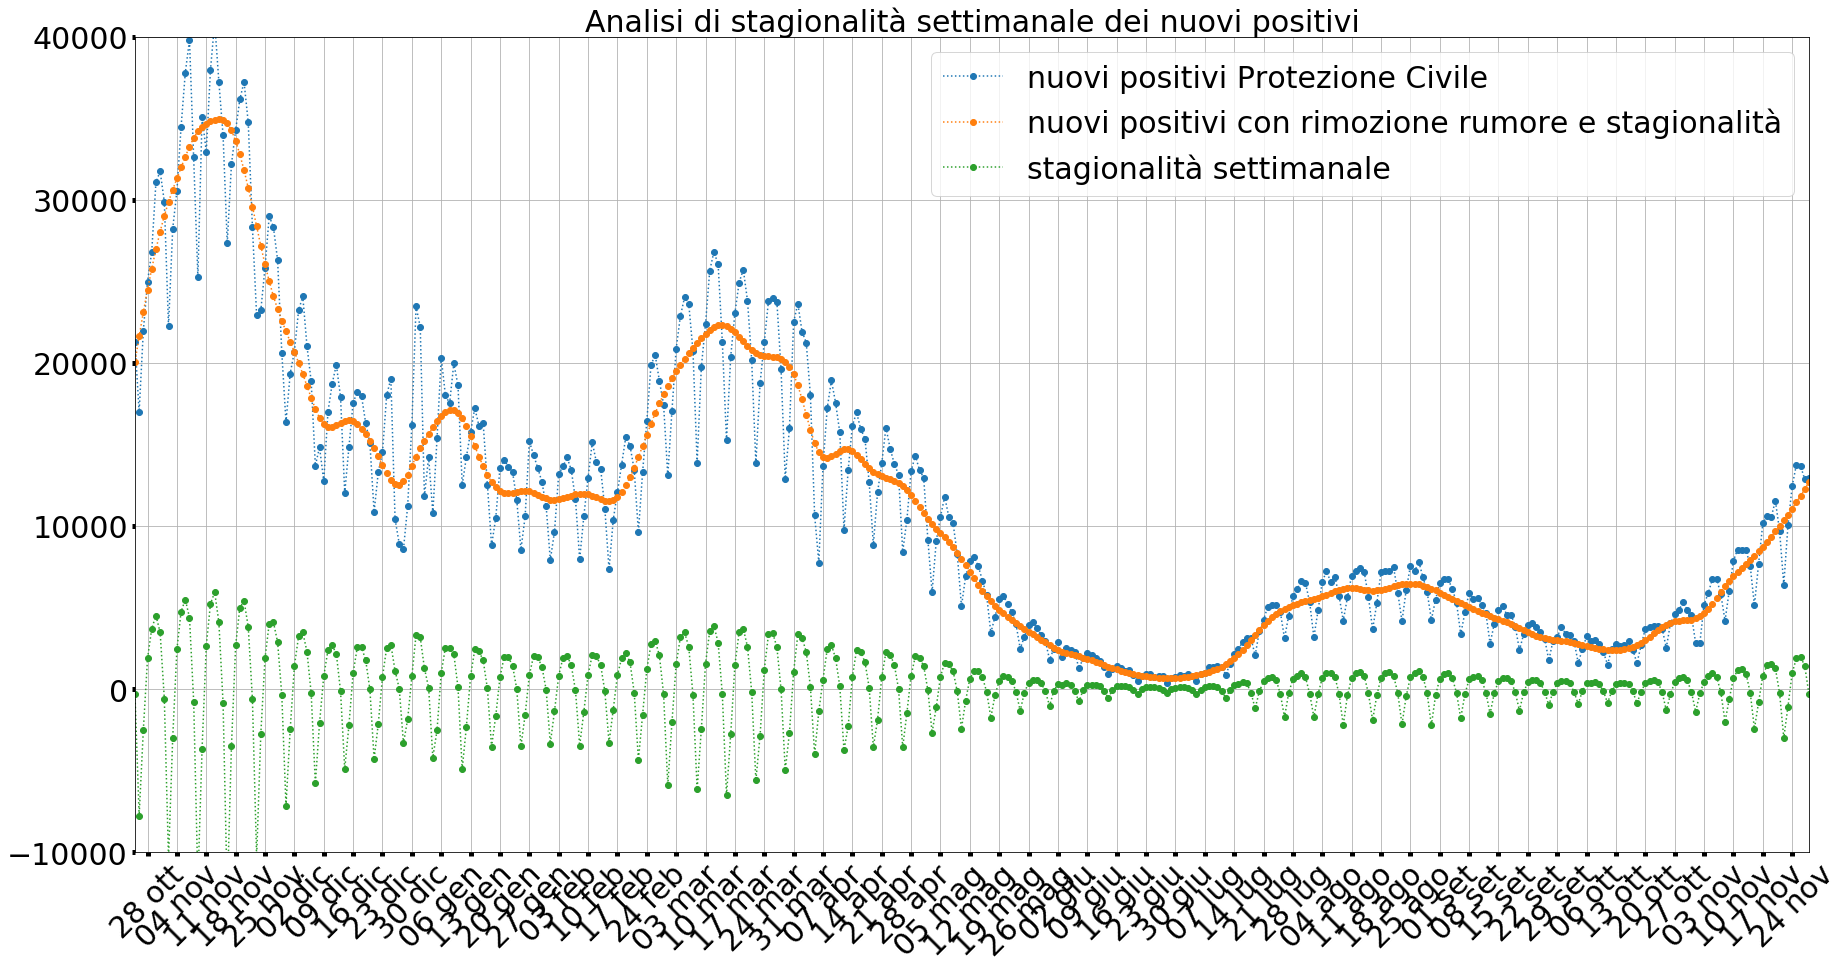

In [10]:
plotting.plot_series(
    title='Analisi di stagionalità settimanale dei nuovi positivi',
    data=[{
        'df': DPC_data,
        'xfield': 'data',
        'yfields':[
            'nuovi_positivi', 
            'nuovi_positivi_deseason_smoothed',
            'nuovi_positivi_deseason_seasonality'
        ],
        'labels': [
            'nuovi positivi Protezione Civile',
            'nuovi positivi con rimozione rumore e stagionalità',
            'stagionalità settimanale'
        ]
    }],
    xlim=(datetime(2020,10,25), DPC_data.data.max()),
    ylim=(-10000,40000),
    img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH,'italy/nuovi_casi'),
    legend_loc="upper right"
)

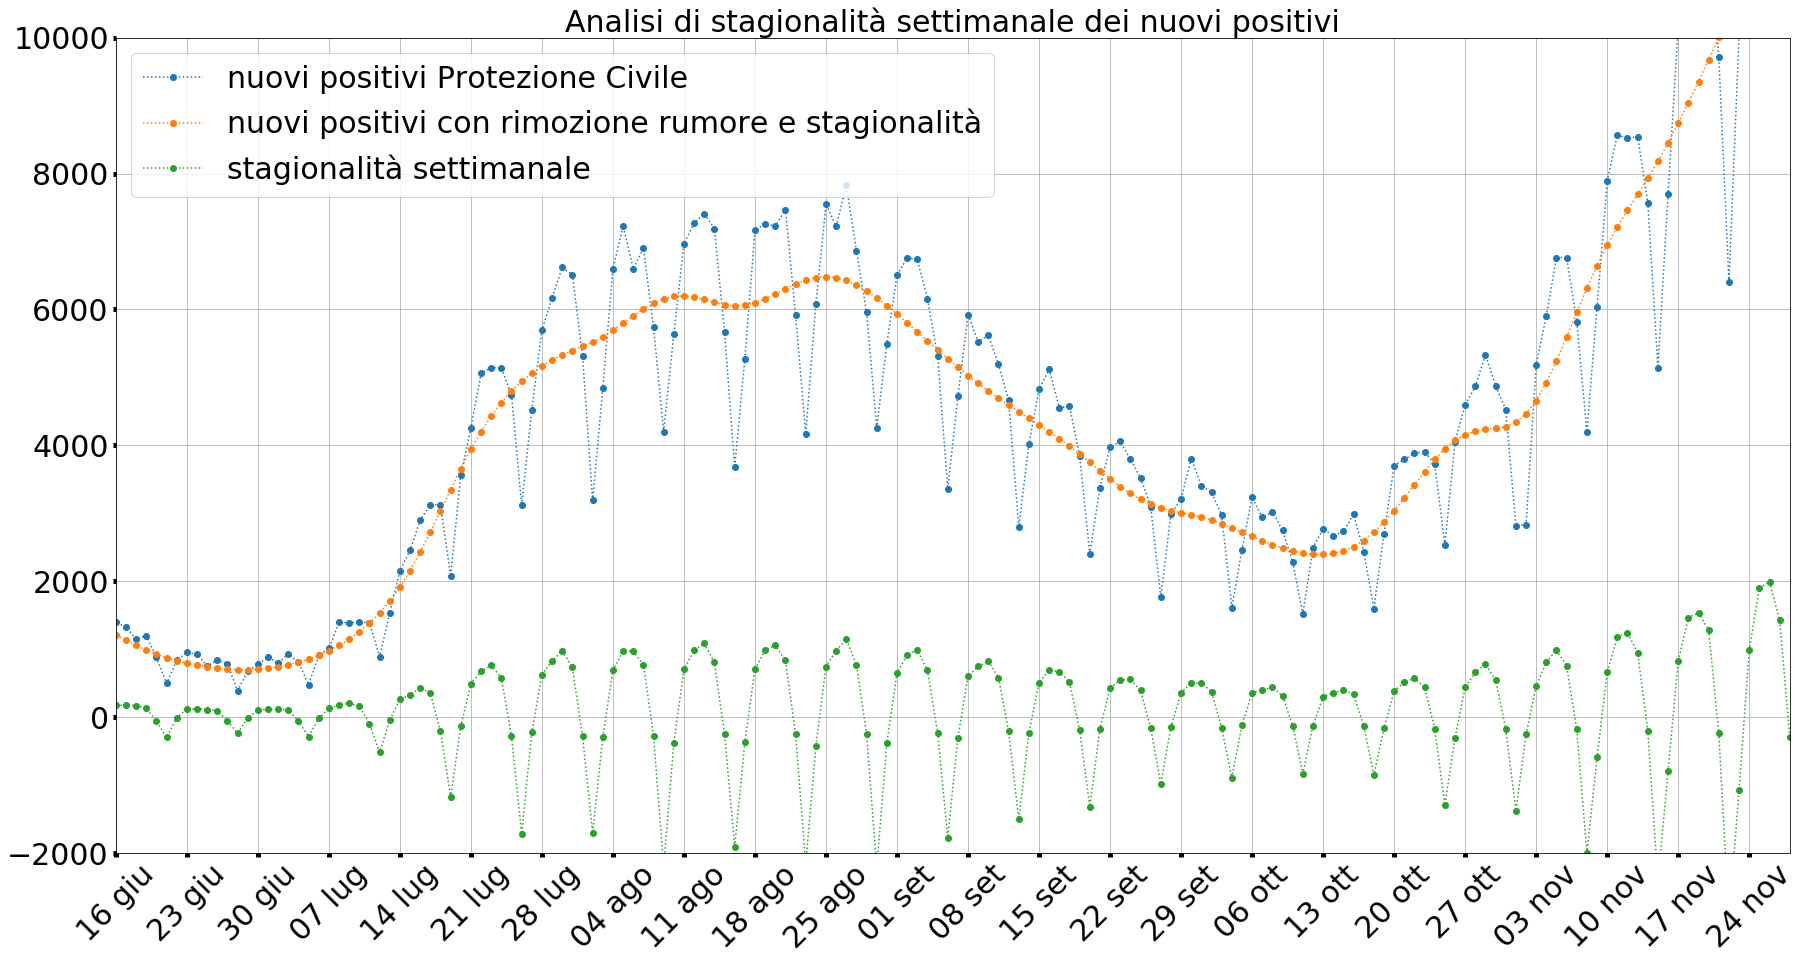

In [11]:
plotting.plot_series(
    title='Analisi di stagionalità settimanale dei nuovi positivi',
    data=[{
        'df': DPC_data,
        'xfield': 'data',
        'yfields':[
            'nuovi_positivi', 
            'nuovi_positivi_deseason_smoothed',
            'nuovi_positivi_deseason_seasonality'
        ],
        'labels': [
            'nuovi positivi Protezione Civile',
            'nuovi positivi con rimozione rumore e stagionalità',
            'stagionalità settimanale'
        ]
    }],
    xlim=(datetime(2021,6,16), DPC_data.data.max()),
    ylim=(-2000,10000),
    #img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH,'italy/nuovi_casi'),
    legend_loc="upper left"
)

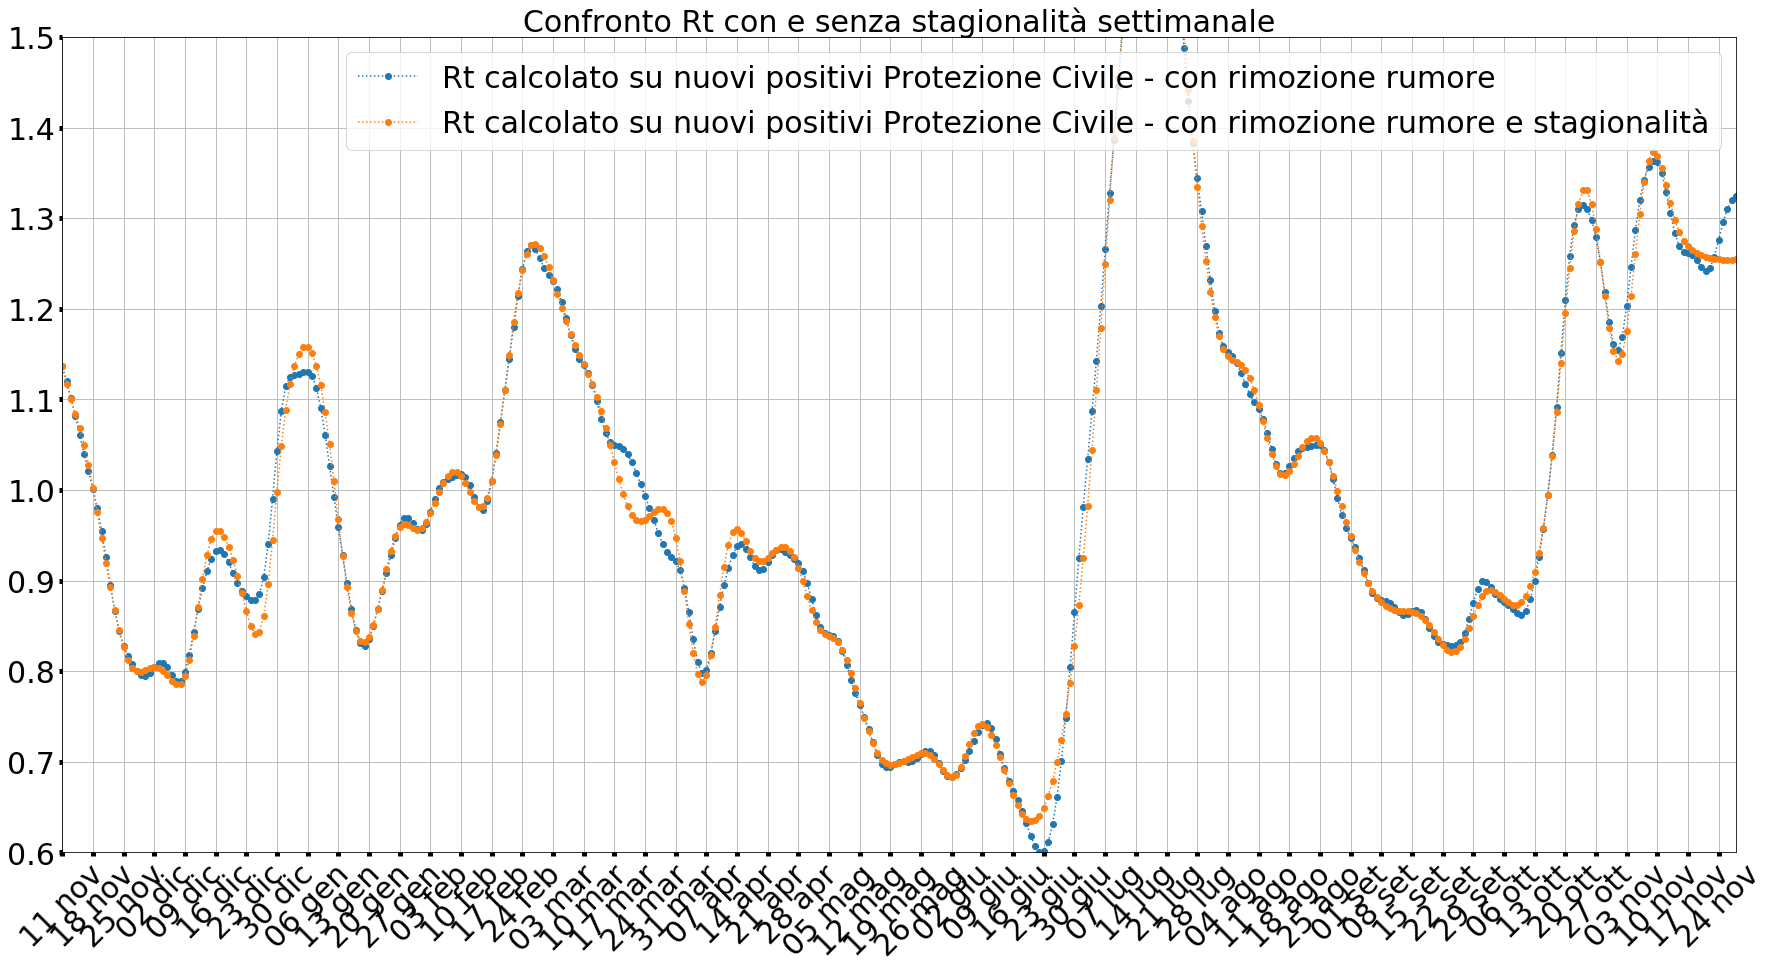

In [12]:
plotting.plot_series(
    title='Confronto Rt con e senza stagionalità settimanale',
    data=[{
        'df':DPC_data,
        'xfield': 'data',
        'yfields':[
            'nuovi_positivi_smoothed_Rt',
            'nuovi_positivi_deseason_smoothed_Rt', 
        ],
        'labels':[
            'Rt calcolato su nuovi positivi Protezione Civile - con rimozione rumore',
            'Rt calcolato su nuovi positivi Protezione Civile - con rimozione rumore e stagionalità',
        ]
    }],
    #img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH,'Rt_seasonality.{}'),
    xlim=(datetime(2020,11,11), DPC_data.data.max()),
    ylim=(0.6,1.5),
    legend_loc="upper right"
)

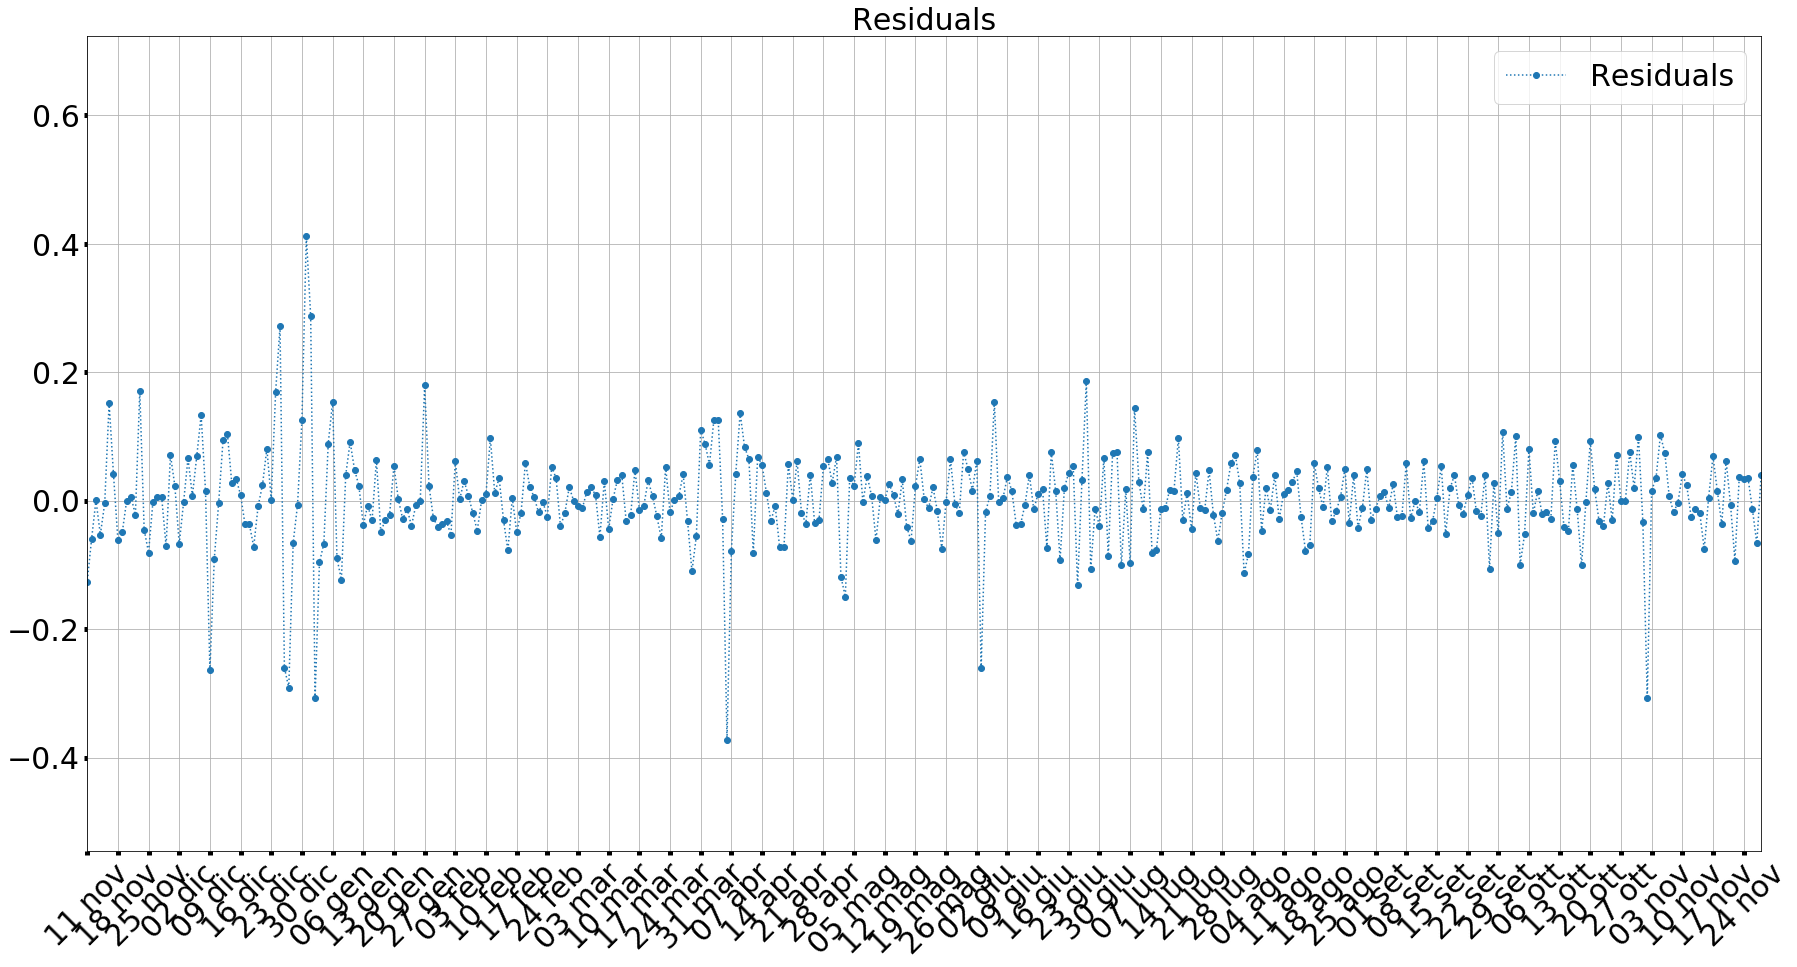

In [13]:
plotting.plot_series(
    title='Residuals',
    data=[{
        'df':DPC_data,
        'xfield': 'data',
        'yfields':[
            'nuovi_positivi_deseason_relative_residuals',
        ],
        'labels':[
            'Residuals',
        ]
    }],
    #img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH,'Rt_seasonality.{}'),
    xlim=(datetime(2020,11,11), DPC_data.data.max()),
    #ylim=(0.6,1.3),
    legend_loc="upper right"
)

## Distribution of residuals

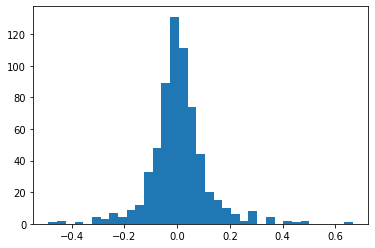

In [14]:
_=plt.hist(DPC_data.nuovi_positivi_deseason_relative_residuals,bins=35)

# Predict the next value of new cases

From the base formula for $R_t$:
$$\large{R_t = \frac{I_t}{\sum_{s=1}^t w_s I_{t-s}}}$$

we can compute the next $I_{t+1}$ value, given $R_{t+1}$:

$$\large{{I_{t+1}} = R_{t+1} \times {\sum_{s=1}^{t+1} w_s I_{t+1-s}}}$$

$$s'=s-1$$

$$\large{{I_{t+1}} = R_{t+1} {\sum_{s'=0}^{t} w_{s'+1} I_{t-s'}}}$$

Using Taylor to expand $R_{t+1}$:

$$R(t+dt) = R(t) + dR(t)dt + \frac{1}{2} d^2R(t) dt^2$$
$$R(t+\Delta t) = R(t) + \Delta R(t)\Delta t + \frac{1}{2} \Delta^2R(t) \Delta t^2$$
$$\Delta t = 1$$
$$R(t+1) = R(t) + [R(t)-R(t-1)] + \frac{1}{2} [R(t)-R(t-1)-(R(t-1)-R(t-2))]$$
$$ = 2R(t)-R(t-1) + \frac{1}{2} [R(t)-2R(t-1)+R(t-2)]$$
$$ = \frac{3}{2} R(t) - 2 R(t-1) +\frac{1}{2} R(t-2)$$

We finally have:
$$\large{{I_{t+1}} = \left[\frac{3}{2} R_t - 2 R_{t-1} +\frac{1}{2} R_{t-2} \right] {\sum_{s'=0}^{t} w_{s'+1} I_{t-s'}}}$$

# Obtain the confidence interval from the predictions

$$\large{X_t = S_t + E_t}$$

where:
- $X$ is the original signal
- $S$ is the seasonal component
- $E$ is the deseasoned component

$$\large{E_t = T_t + \epsilon_t}$$

where:
- $T$ is the smoothed trend
- $\epsilon$ is the residual

$$\large{X_{t+1}= T_{t+1} + \epsilon_{t+1} + S_{t+1}}$$

where we can approximate $X_{t+1}$ with the following:
- $T_{t+1}$ is approximated via Taylor on the previous $R_t$ knowledge
- $\epsilon_{t+1}$ is sampled from a gaussian distribution of the relative residuals, with $\mu=AVG_{t-7}(\epsilon_t/T_t)$ and $\sigma=STD_{t-7}(\epsilon_t/T_t)$

- $S_{t+1}$ is approximated with taylor from the last $S_{t+1-period}$ known value

## Strategy:

1. deseason once and obtain $T, R, S$
2. with those sample multiple values of $X_{t+1}$ based on taylor expantion and the hypotesis that tomorrow new cases can range from `0.8` to `1.2` as many the cases of today, as from $T$
3. generate multiple possible series $X^i$ with $i$ spanning the samples
4. deseason again each of the possible series
5. drop the last value as it is tomorrow
6. use the obtained $T$ as the truth value for the posterior in MCMC, adding noise sampled from $\epsilon_t$

This strategy is implemented essentially in two functions:

#### `covid19_pytoolbox.modeling.datarevision.seasonal.draw_expanded_series`:
`draw_expanded_series` performs steps 1 to 4, with as many `draws` future scenario


#### `covid19_pytoolbox.modeling.Rt.bayesian.MCMC_sample`:
`MCMC_sample` perform step 6, by sampling $R_t$ and $\epsilon_t$  in 4 chains with 500 samples each, forcing the number of new cases to be Bernoulli distributed with respect to the trend $T$.

By iterating `MCMC_sample` on each draw from the previous steps, the method can accounts for data revision, as each draw is a possibile future scenario ranging from `0.8` to `1.2` wrt the current trend $T$.

In [15]:
def save_MCMC_sampling(df, column, trace, pastdays, interval=0.95, start=0):
    interval_frac = int(interval*100)
    sampling_mean = np.mean(trace['r_t'], axis=0)

    df[f'{column}_Rt_MCMC_pastdays_{pastdays:02d}'] = padnan(sampling_mean, (start,pastdays))
    

    #credible interval
    sampling_hdi = pm.stats.hpd(trace['r_t'], hdi_prob=interval)
    df[f'{column}_Rt_MCMC_HDI_{interval_frac}_min_pastdays_{pastdays:02d}'] = padnan(
        sampling_hdi[:,0], (start,pastdays))
    df[f'{column}_Rt_MCMC_HDI_{interval_frac}_max_pastdays_{pastdays:02d}'] = padnan(
        sampling_hdi[:,1], (start,pastdays))


In [16]:
# set the following to anything grater than 0 to compute Rt series based on past days values on new cases
# this is helpful in checking how the method is robust against data revision

PASTDAYS_BEGIN=0

draws = 5

for pastdays in range(PASTDAYS_BEGIN-1,-1,-1):

    if pastdays == 0:
        sl = np.s_[:]
    else:
        sl = np.s_[:-pastdays]
        
    new_cases = DPC_data.nuovi_positivi.to_numpy()[sl]
    
    new_cases_expanded = draw_expanded_series(
            new_cases, draws=draws, season_period=7, trend_alpha=ALPHA, difference_degree=2, 
            alpha=alpha, beta=beta, truncate=False
        )
        
    new_cases_smoothed, rel_eps, padding_left = smooth_and_drop(
        new_cases_expanded, season_period=7, trend_alpha=100.,difference_degree=2)
        
    simulations = []
    for new_cases_s, rel_eps_s in zip(new_cases_smoothed, rel_eps):        
        model_, trace_ = MCMC_sample(
            onset=new_cases_s[~np.isnan(new_cases_s)],
            alpha=alpha, beta=beta,
            rel_eps=rel_eps_s[~np.isnan(rel_eps_s)],
            eps_window=1,
            start=0, window=None,
            chains=4,
            tune=500,
            draws=500,
            cores=4,
            dry=False,
            progressbar=False
        )
        simulations.append(trace_)

    sampled_Rt = np.array([t['r_t'] for t in simulations])
    combined_trace = {'r_t': sampled_Rt.reshape((-1,sampled_Rt.shape[2]))}

    save_MCMC_sampling(
        DPC_data, 'nuovi_positivi_smooth_deseas', combined_trace, pastdays, interval=0.95, start=padding_left+1)

    
    DPC_data.to_pickle(os.path.join(BASE_DATA_PATH,'computed/WIP/deseason_MCMC_Rt.pickle'))

# Calculation

The actual simulations run on virtual machines on IBM Cloud via the scripts contained in the `applications/` dir.

Here we just load the pickles generated by the simulations.

In [17]:
italy_calc_data = pd.read_pickle(
    os.path.join(BASE_DATA_PATH, 
                 f'computed/italy/{date_}_futbound_08_12_National_MCMC_Rt_pastdays_{pastdays}_{pastdays}.pickle')
)

In [18]:
italy_calc_data.sort_values(by='data', inplace=True)
italy_calc_data.reset_index(drop=True, inplace=True)

## Save computed data to csv and excel

In [19]:
procdata_to_save = italy_calc_data.loc[
    italy_calc_data.data>"2020-03-01",
    [
        "data", 
        "nuovi_positivi",
        f"nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_{pastdays}",
        f"nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_min_pastdays_{pastdays}",
        f"nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_max_pastdays_{pastdays}"
    ]
].sort_values(by="data", ascending=False)

procdata_to_save.rename(columns={
    f"nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_{pastdays}": "Rt",
    f"nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_min_pastdays_{pastdays}": "Rt_interv_cred_min",
    f"nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_max_pastdays_{pastdays}": "Rt_interv_cred_max",
}, inplace=True)

procdata_to_save.to_csv(
    os.path.join(BASE_DATA_PATH, "computed/TD-covid19-ita-andamento-nazionale_Rt.csv"),
    float_format='%.2f',
    index=False
)
procdata_to_save.to_excel(
    os.path.join(BASE_DATA_PATH, "computed/TD-covid19-ita-andamento-nazionale_Rt.xlsx"),
    float_format='%.2f',
    index=False        
)

# ISS Data

To allow for comparison with official $Rt$ calculation, we load official data from a static dataset which we update manually every week.

In [20]:
ISS_Rt = ISS.read_weekly_Rt_from_local()
ISS_Rt_clean = ISS.preprocess(ISS_Rt)
ISS_Rt_clean.tail()

,computation_time_range_start,computation_time_range_end,Rt,Rt_95_min,Rt_95_max,Rt_95_err_max,Rt_95_err_min,Rt_reference_date
63,2021-10-06,2021-10-19,0.96,0.83,1.16,0.20,0.13,2021-10-12 23:59:00
64,2021-10-13,2021-10-26,1.15,0.93,1.28,0.13,0.22,2021-10-19 23:59:00
65,2021-10-20,2021-11-02,1.21,1.08,1.31,0.10,0.13,2021-10-26 23:59:00
66,2021-10-27,2021-11-09,1.21,1.14,1.26,0.05,0.07,2021-11-02 23:59:00
67,2021-11-03,2021-11-16,1.23,1.15,1.30,0.07,0.08,2021-11-09 23:59:00


In [21]:
def plot_simulation_results(
    simdf, ISSdf, xmin=datetime(2020,7,25), xmax=None, ylim=(0.2,2), 
    img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH, 'TD_Rt_computation_MCMC_300dpi')):
    
    if not xmax:
        xmax = simdf.data.max()
        
    plotting.plot_series(
        title='',
        message='Aggiornamento del {}'.format(xmax.strftime('%d %b %Y')),
        data=[
            {
                'df': ISSdf,
                'xfield': 'Rt_reference_date',
                'yfields': ['Rt'],
                'bars': [['Rt_95_err_min','Rt_95_err_max']],
                'timeranges': [['computation_time_range_start', 'computation_time_range_end']],
                'labels': ['Stima di $R_t$ pubblicata dall\'Istituto Superiore di Sanità, con range di possibile variazione nel periodo'],
                'colors': ['blue']
            },        
            {
                'df': simdf,
                'xfield': 'data',
                'yfields': [
                    f'nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_{pastdays}', 
                ],
                'fill_between': [
                    f'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_min_pastdays_{pastdays}',
                    f'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_max_pastdays_{pastdays}',
                ],
                'labels': [
                    f'Stima di $R_t$ sul valore dei $nuovi\_positivi$ giornalieri, dati Protezione Civile',
                ],
                'colors':['orange']
            },
        ],
        legend_fontsize=27,
        xlim=(xmin, xmax),
        ylim=ylim,
        legend_loc='lower right',
        img_file_path_without_extension=img_file_path_without_extension,
        dpi=150,
        quality=60,
        tick_fontsize=20,
        major_formatter=mdates.DateFormatter("%d %b %y")
    )

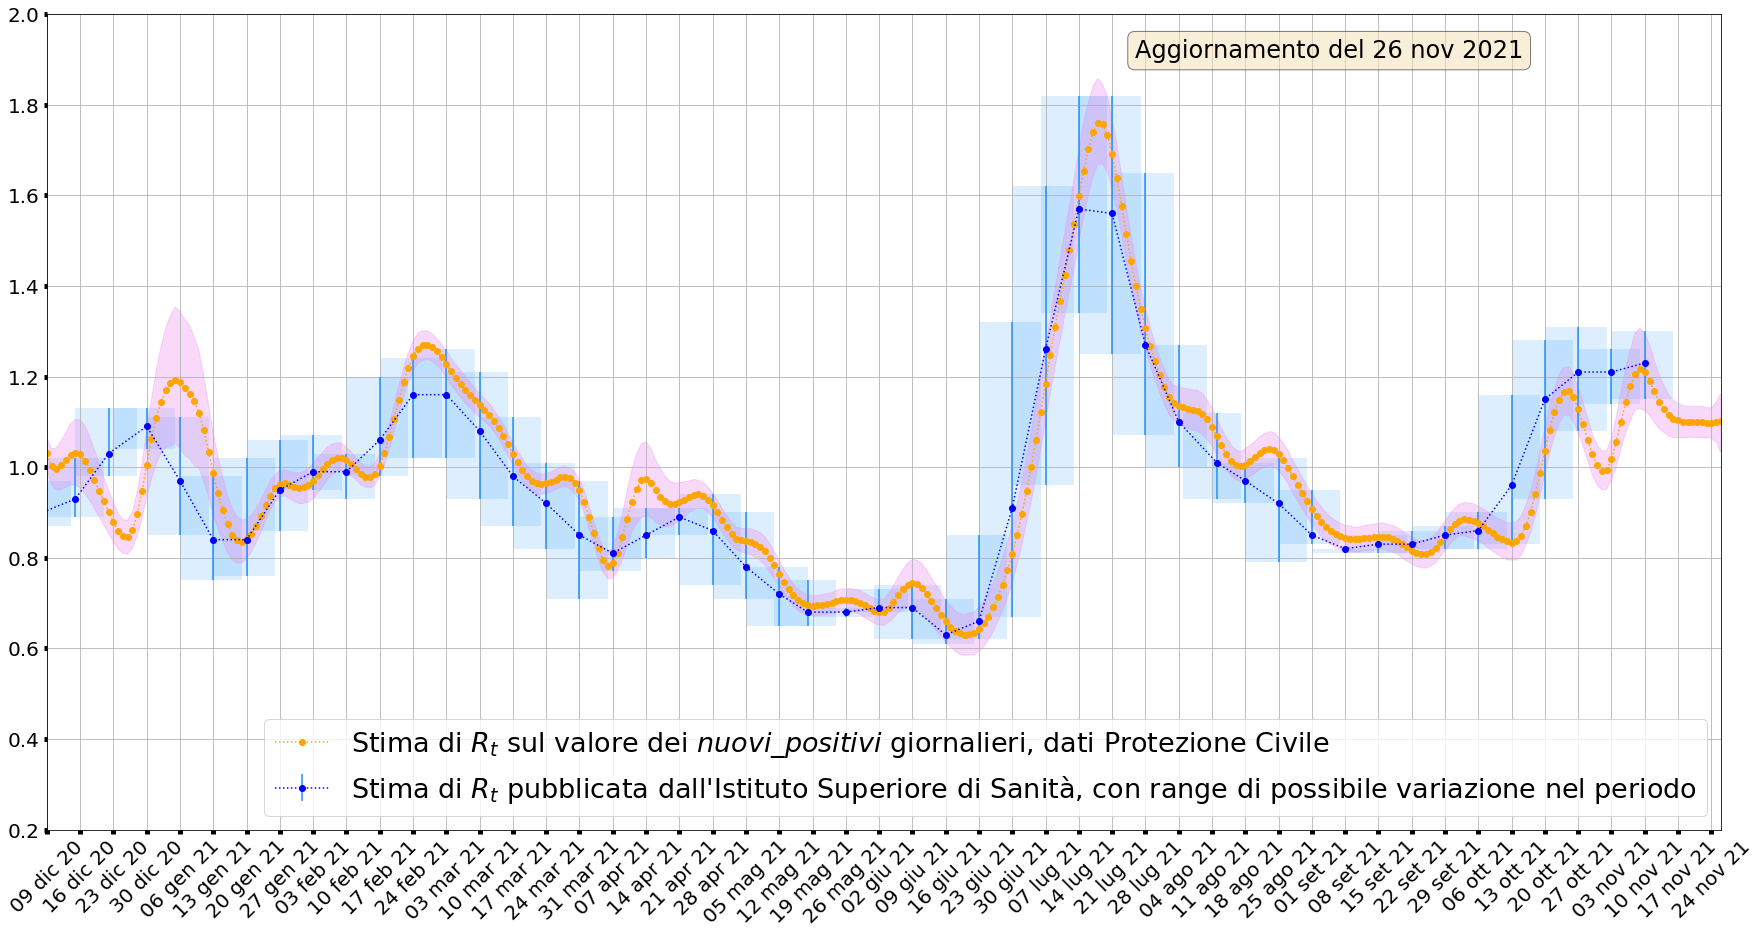

In [22]:
plot_simulation_results(
    simdf=italy_calc_data, ISSdf=ISS_Rt_clean, xmin=datetime(2020,12,9), xmax=datetime(2021,11,26)) #

In [23]:
italy_calc_data.set_index("data").tail().T

data,2021-11-24,2021-11-25,2021-11-26,2021-11-27,2021-11-28
stato,ITA,ITA,ITA,ITA,ITA
ricoverati_con_sintomi,4629,4689,4748,4826,4964
terapia_intensiva,573,588,606,624,638
totale_ospedalizzati,5202,5277,5354,5450,5602
isolamento_domiciliare,154115,161321,167264,173496,180841
totale_positivi,159317,166598,172618,178946,186443
variazione_totale_positivi,4807,7281,6020,6328,7497
nuovi_positivi,12448,13764,13686,12877,12932
dimessi_guariti,4661853,4668257,4675867,4682318,4687701
deceduti,133415,133486,133537,133627,133674


In [24]:
italy_calc_data.tail(15)

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,...,imported,total,imported_ratio,imported_ratio_avg14,imported_ratio_std14,imported_ratio_shifted,nuovi_positivi_corrected,nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_002,nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_min_pastdays_002,nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_max_pastdays_002
629,2021-11-14,ITA,3647,458,4105,115125,119230,4118,7569,4608056,...,NaN,NaN,NaN,NaN,NaN,0.128205,6598.615385,1.127364,1.076849,1.180687
630,2021-11-15,ITA,3808,475,4283,116592,120875,1645,5144,4611566,...,NaN,NaN,NaN,NaN,NaN,0.128205,4484.512821,1.115028,1.069002,1.160593
631,2021-11-16,ITA,3970,481,4451,118945,123396,2521,7698,4616786,...,NaN,NaN,NaN,NaN,NaN,0.128205,6711.076923,1.107325,1.065130,1.147291
632,2021-11-17,ITA,4060,486,4546,122539,127085,3689,10172,4623192,...,NaN,NaN,NaN,NaN,NaN,0.128205,8867.897436,1.103158,1.065259,1.141115
633,2021-11-18,ITA,4088,503,4591,127922,132513,5428,10638,4628340,...,NaN,NaN,NaN,NaN,NaN,0.128205,9274.153846,1.100719,1.064778,1.135804
634,2021-11-19,ITA,4145,512,4657,132473,137130,4617,10544,4634229,...,NaN,NaN,NaN,NaN,NaN,0.128205,9192.205128,1.099897,1.065855,1.134630
635,2021-11-20,ITA,4250,512,4762,138639,143401,6271,11555,4639449,...,NaN,NaN,NaN,NaN,NaN,0.128205,10073.589744,1.100012,1.065946,1.134417
636,2021-11-21,ITA,4345,520,4865,143895,148760,5359,9709,4643751,...,NaN,NaN,NaN,NaN,NaN,0.128205,8464.256410,1.099605,1.064750,1.134464
637,2021-11-22,ITA,4507,549,5056,146458,151514,2754,6404,4647330,...,NaN,NaN,NaN,NaN,NaN,0.128205,5582.974359,1.099075,1.064890,1.134548
638,2021-11-23,ITA,4597,560,5157,149353,154510,2996,10047,4654295,...,NaN,NaN,NaN,NaN,NaN,0.128205,8758.923077,1.098499,1.064539,1.131354


In [25]:
1.067152-1.255754

-0.18860199999999994

# compare $R_t$ and new admissions

In [26]:
ricoveri = pd.read_csv(
    os.path.join(BASE_DATA_PATH, 'sources/ISS/covid_19-iss_2021-11-28T22:34:54+00:00.ricoveri.csv'),
    #parse_dates=['iss_date', 'DATARICOVERO1']
)

ricoveri.loc[ricoveri.RICOVERI=='<5',['RICOVERI']]=5
ricoveri.RICOVERI = ricoveri.RICOVERI.astype(int)
ricoveri.dropna(inplace=True)

ricoveri['data']= pd.to_datetime(
    ricoveri.DATARICOVERO1,
    format='%d/%m/%Y'
)

ricoveri.sort_values(by='data', inplace=True)
ricoveri.reset_index(drop=True, inplace=True)


In [27]:
ricoveri_stable = ricoveri.loc[ricoveri.data<"2021-11-21"].copy()

RSVD_smooth_data_generic(
    ricoveri_stable, ['RICOVERI'], 
    alpha, beta, 
    season_period=7, trend_alpha=100, difference_degree=4)

['RICOVERI']
RICOVERI_deseason
info_cri:  -0.904122036890685
info_cri:  1.8206096720606033
TIC R2: 0.9960366988840745
patterns: 1
(   -15.026907836923302,
    1.0033117312583054e-27,
    20,
    612,
    {   '1%': -3.4410802944179686,
        '10%': -2.569291225276603,
        '5%': -2.8662741915097736},
    -743.5949489664335)
new columns generated:
[   'RICOVERI_deseason',
    'RICOVERI_deseason_seasonality',
    'RICOVERI_deseason_smoothed',
    'RICOVERI_deseason_residuals',
    'RICOVERI_deseason_relative_residuals',
    'RICOVERI_deseason_smoothed_Rt']


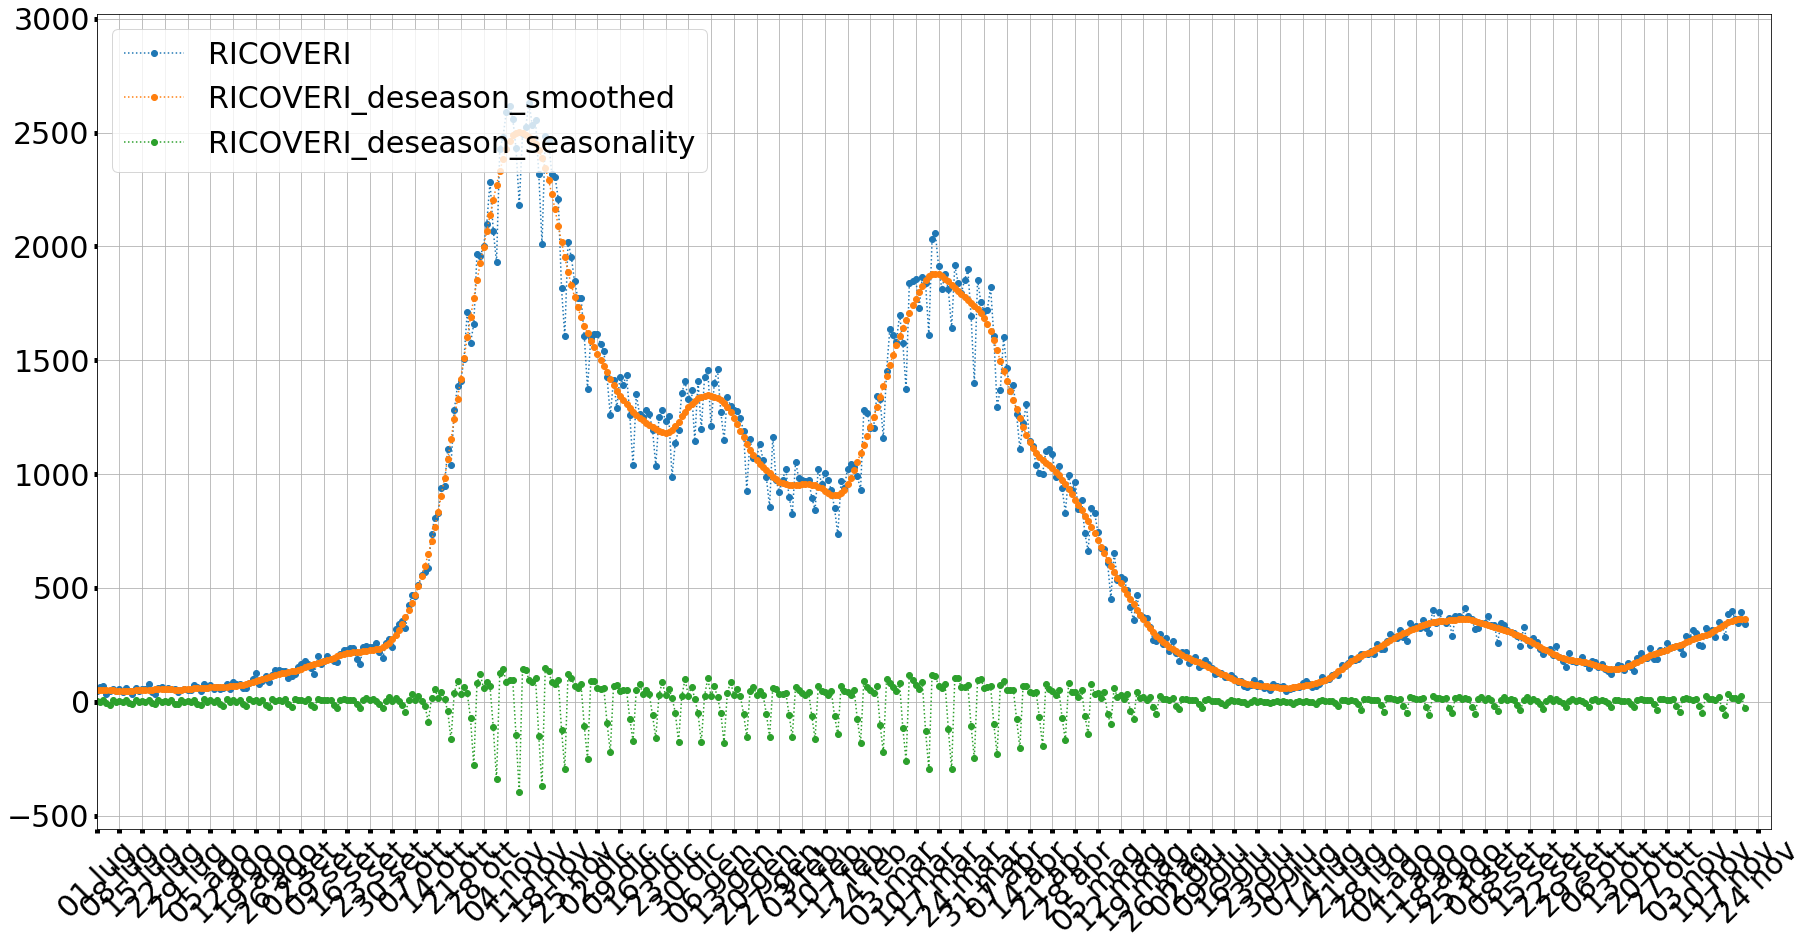

In [28]:
plotting.plot_series(
    df=ricoveri_stable,
    yfields=[
        'RICOVERI', 
        'RICOVERI_deseason_smoothed',
        'RICOVERI_deseason_seasonality'
    ],
    #xlim=(datetime(2020,7,25), datetime(2020,10,1)),#DPC_data.data.max()),
    #ylim=(-1000,1000),
    xlim=(datetime(2020,7,1), DPC_data.data.max()),
    #ylim=(-10000,40000),
    legend_loc="upper left"
)

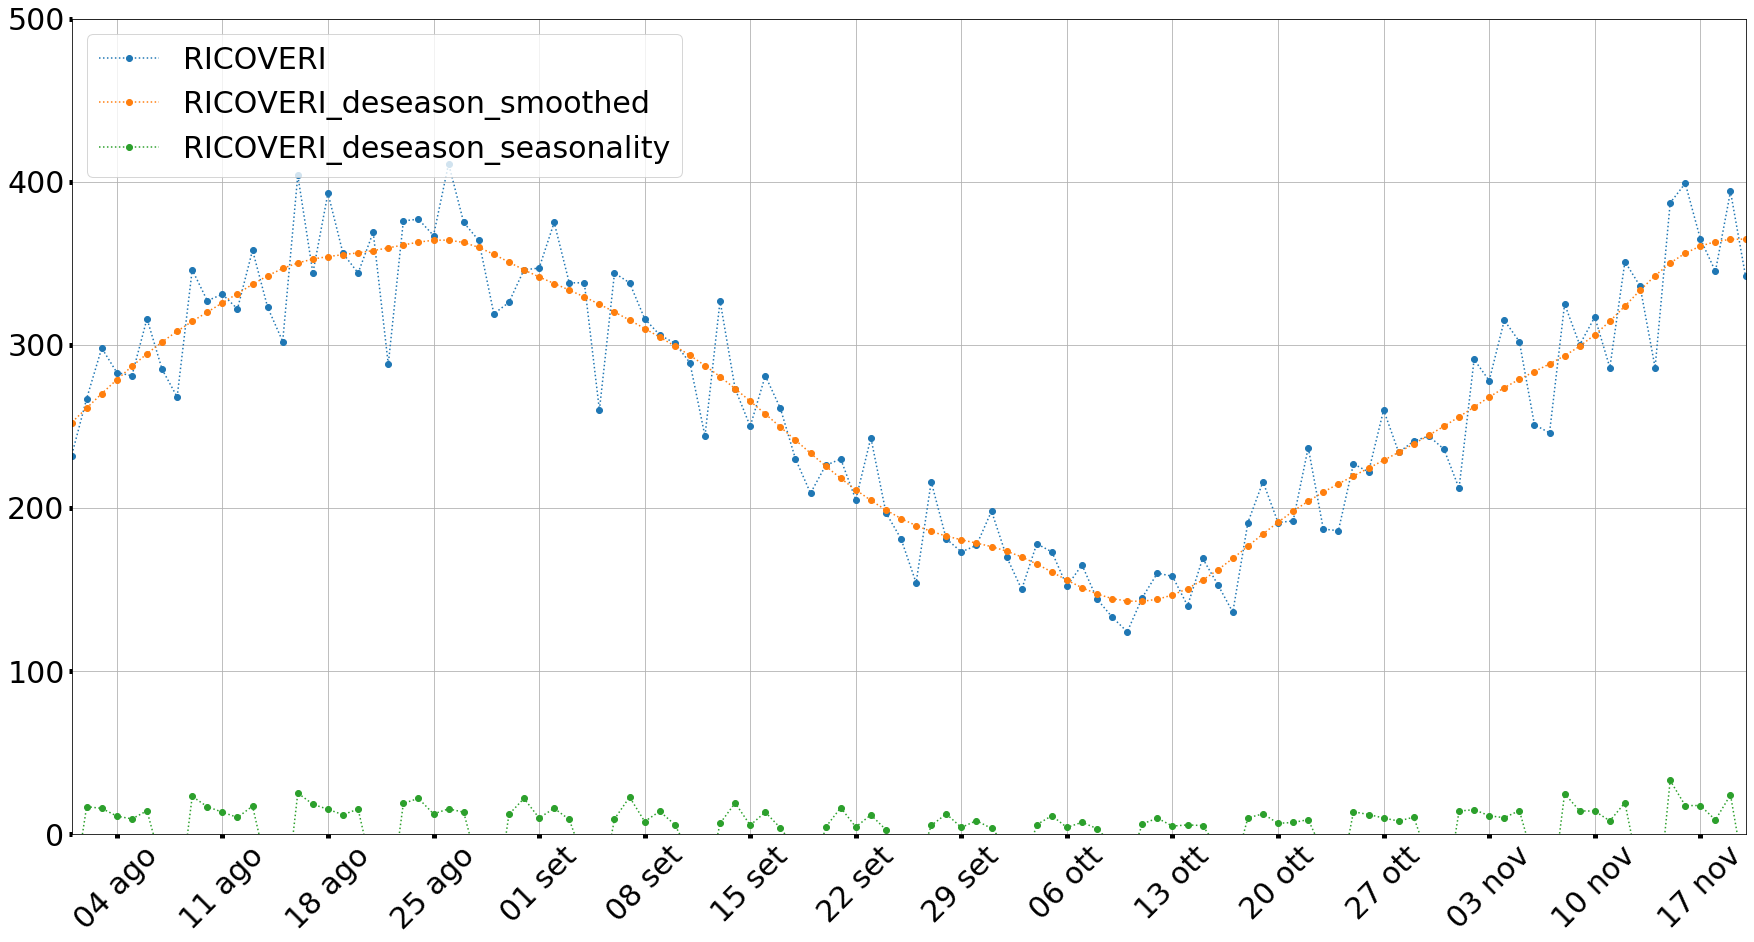

In [29]:
plotting.plot_series(
    df=ricoveri_stable,
    yfields=[
        'RICOVERI', 
        'RICOVERI_deseason_smoothed',
        'RICOVERI_deseason_seasonality'
    ],
    xlim=(datetime(2021,8,1), ricoveri_stable.data.max()),
    ylim=(0,500),
    legend_loc="upper left"
)

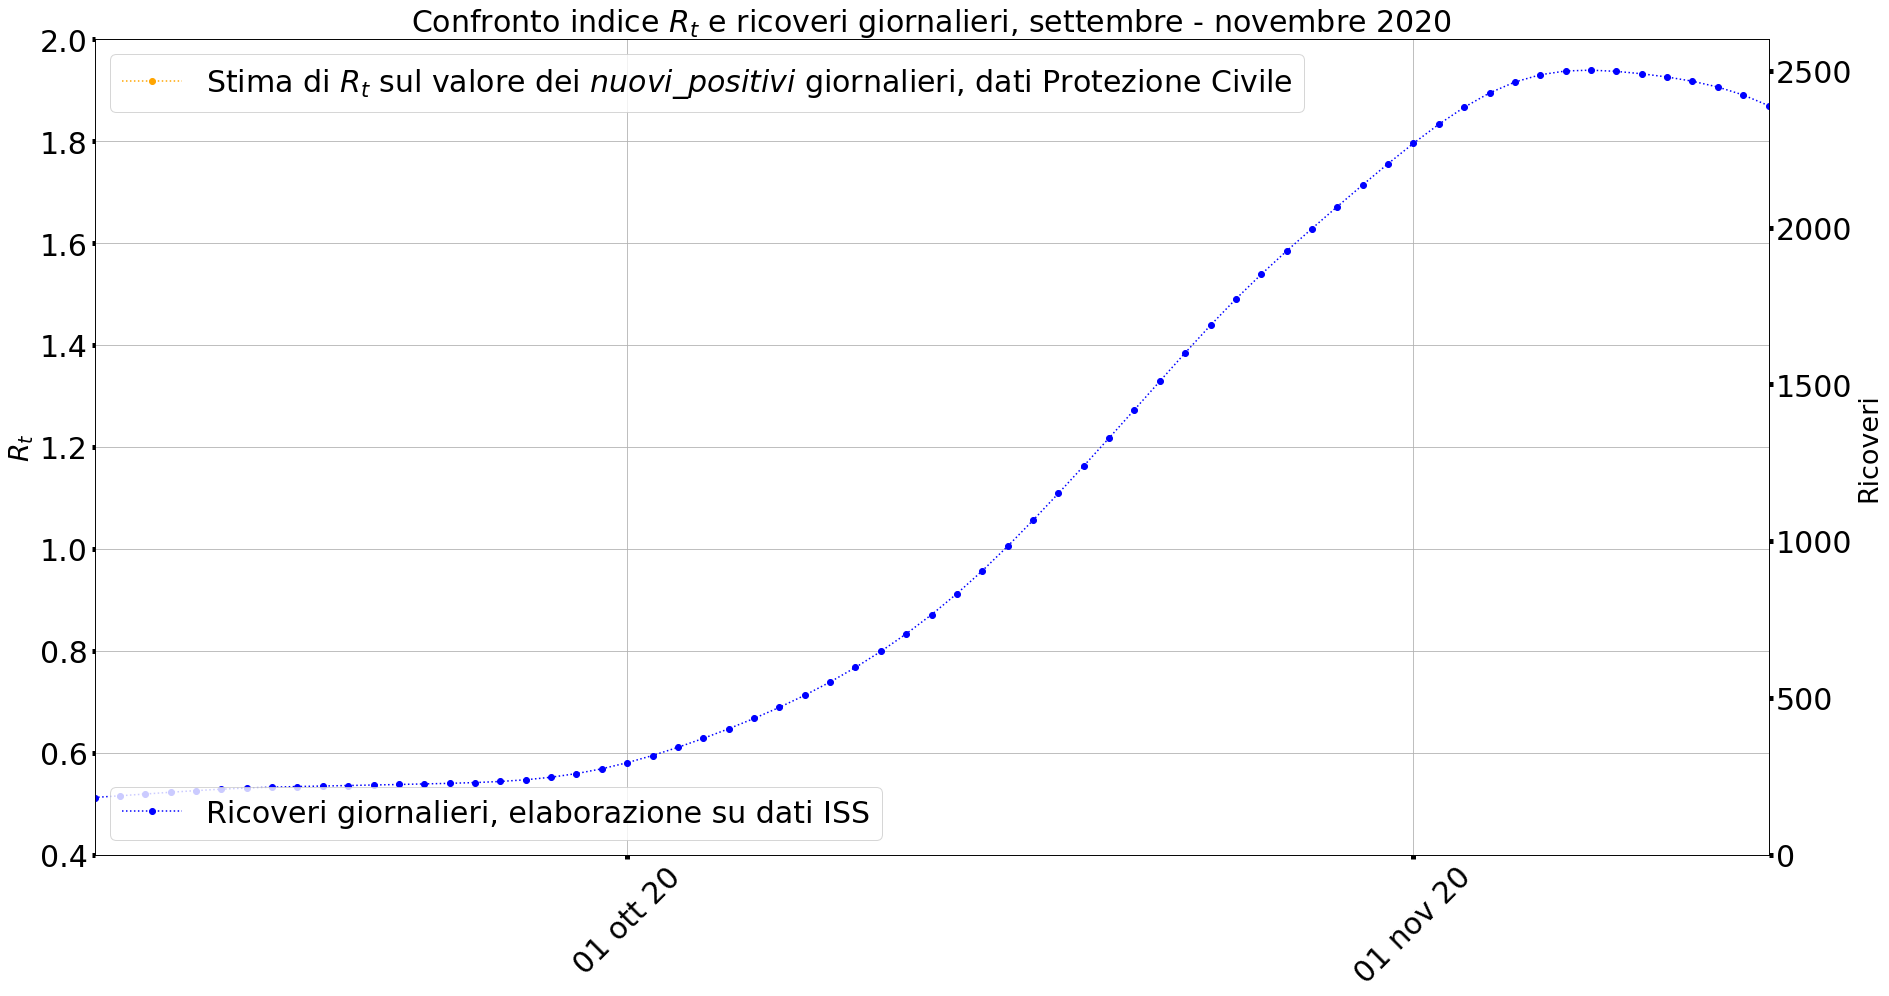

In [30]:
plotting.plot_series(
    title='Confronto indice $R_t$ e ricoveri giornalieri, settembre - novembre 2020',
    data=[
        {
            'df': italy_calc_data,
            'xfield': 'data',
            'yfields': [
                f'nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_{pastdays}', 
            ],
            'fill_between': [
                f'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_min_pastdays_{pastdays}',
                f'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_max_pastdays_{pastdays}',
            ],
            'labels': [
                f'Stima di $R_t$ sul valore dei $nuovi\_positivi$ giornalieri, dati Protezione Civile',
            ],
            'colors':['orange']
        },
        {
            'df': ricoveri_stable,
            'xfield': 'data',
            'yfields': ['RICOVERI_deseason_smoothed'],
            'colors': ['blue'],
            'secondary_ylim': (0,2600),
            'secondary_ylabel': "Ricoveri",
            'labels':['Ricoveri giornalieri, elaborazione su dati ISS']
        },        
    ],
    xlim=(datetime(2020,9,10), datetime(2020,11,15)),#DPC_data.data.max()),
    ylim=(0.4,2),
    y_label='$R_t$',
    #ylim=(-10000,40000),
    legend_loc="upper left",
    img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH, "italy/confr_rt_con_ricoveri_set_nov_2020"),
    dpi=150,
    quality=60
    
)


In [31]:
filt=ricoveri_stable[(ricoveri_stable.data>="2020-09-30")&(ricoveri_stable.data<="2020-10-06")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(7, 10) 274.2289776367723 434.71298348180443 160.48400584503213 58.521899190974594


In [32]:
filt=ricoveri_stable[(ricoveri_stable.data>="2020-10-06")&(ricoveri_stable.data<"2020-10-13")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(7, 10) 434.71298348180443 704.4868166356038 269.77383315379933 62.057919455973895


In [33]:
filt=ricoveri_stable[(ricoveri_stable.data>="2020-10-13")&(ricoveri_stable.data<"2020-10-20")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(7, 10) 765.7424088559239 1240.0052241631627 474.2628153072387 61.93503322035182


In [34]:
filt=ricoveri_stable[(ricoveri_stable.data>="2020-10-20")&(ricoveri_stable.data<"2020-10-27")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(7, 10) 1329.0492761884157 1851.0604232942478 522.0111471058322 39.277034829205846


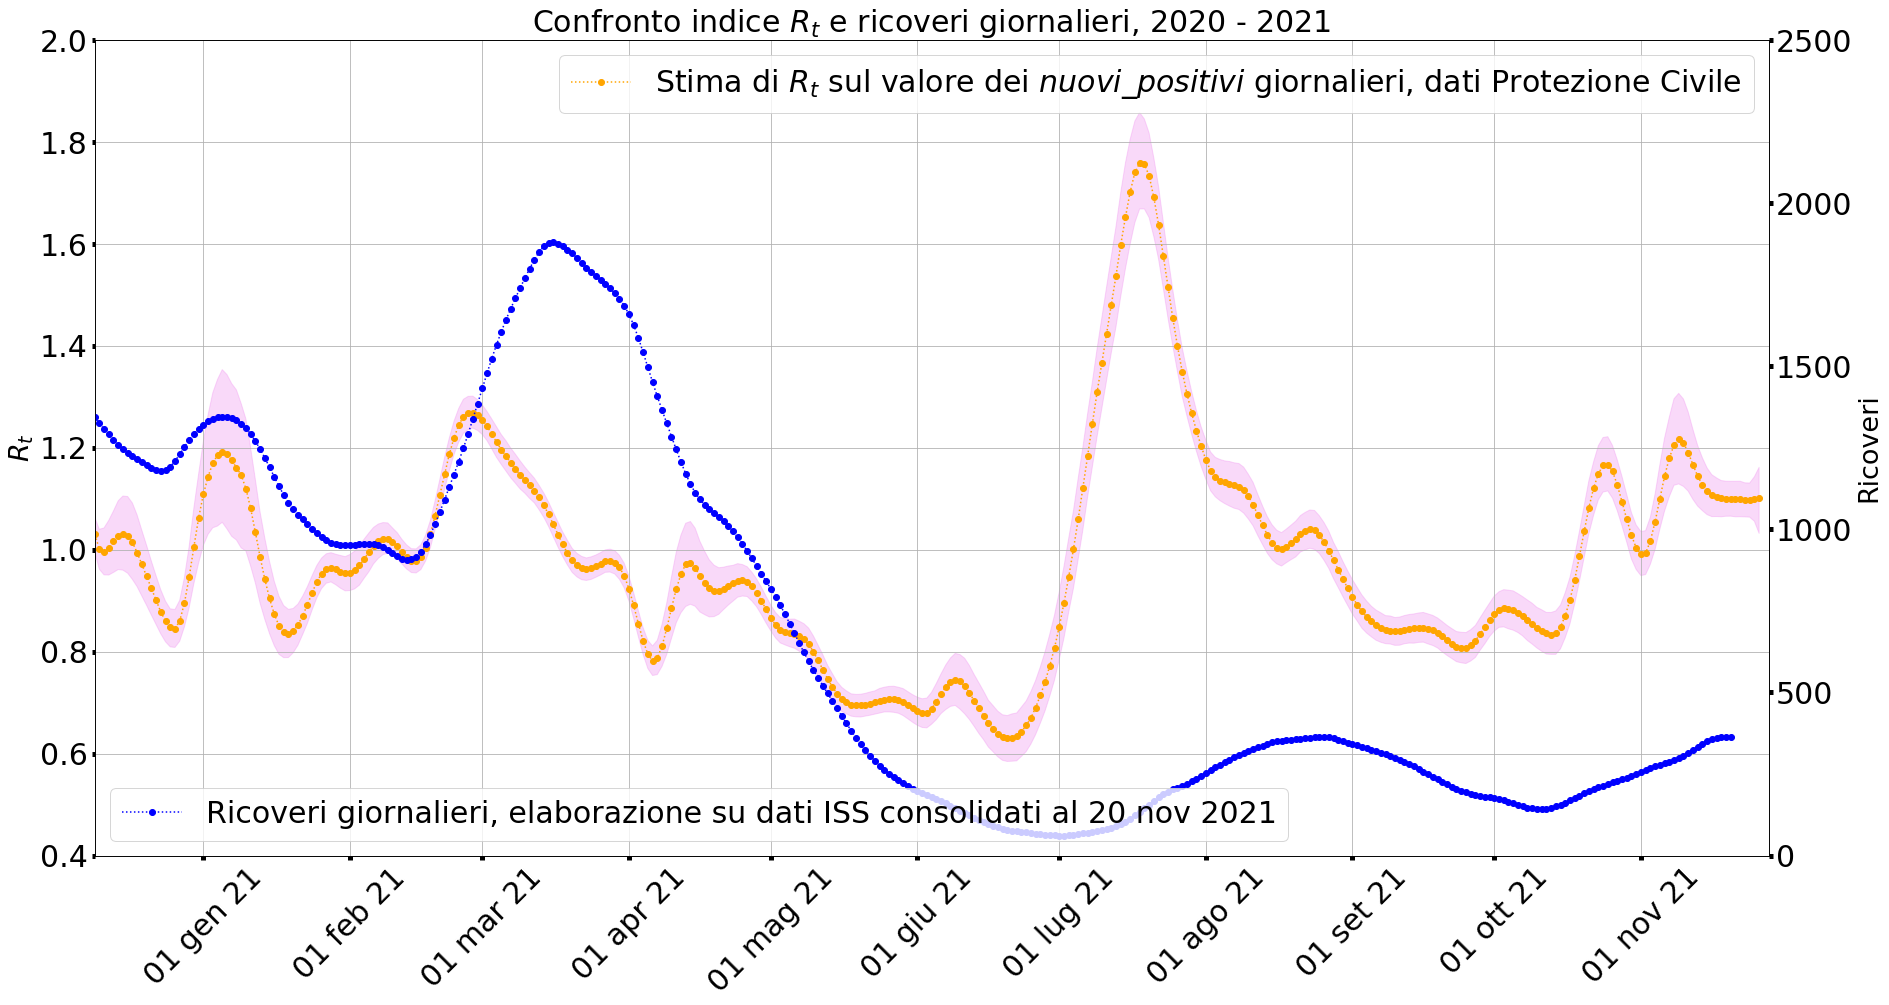

In [35]:
plotting.plot_series(
    title='Confronto indice $R_t$ e ricoveri giornalieri, 2020 - 2021',
    major_locator=mdates.MonthLocator(bymonthday=1),
    major_formatter=mdates.DateFormatter("%d %b"),    
    data=[
        {
            'df': italy_calc_data,
            'xfield': 'data',
            'yfields': [
                f'nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_{pastdays}', 
            ],
            'fill_between': [
                f'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_min_pastdays_{pastdays}',
                f'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_max_pastdays_{pastdays}',
            ],
            'labels': [
                f'Stima di $R_t$ sul valore dei $nuovi\_positivi$ giornalieri, dati Protezione Civile',
            ],
            'colors':['orange']
        },
        {
            'df': ricoveri_stable, #ricoveri[ricoveri.data<="2021-07-11"],
            'xfield': 'data',
            'yfields': ['RICOVERI_deseason_smoothed'],
            'colors': ['blue'],
            'secondary_ylim': (0,2500),
            'secondary_ylabel': "Ricoveri",
            'labels':[f'Ricoveri giornalieri, elaborazione su dati ISS consolidati al {ricoveri_stable.data.max().strftime("%d %b %Y")}']
        },        
    ],
    xlim=(datetime(2020,12,9), italy_calc_data.data.max()),
    ylim=(0.4,2),
    y_label='$R_t$',
    #tick_fontsize=22,
    #ylim=(-10000,40000),
    legend_loc="upper right",
    img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH, "italy/confr_rt_con_ricoveri_2020_2021"),
    dpi=150,
    quality=60,
)


In [36]:
ricoveri_stable[ricoveri_stable.data<="2021-11-09"]

,iss_date,DATARICOVERO1,RICOVERI,data,RICOVERI_deseason,RICOVERI_deseason_seasonality,RICOVERI_deseason_smoothed,RICOVERI_deseason_residuals,RICOVERI_deseason_relative_residuals,RICOVERI_deseason_smoothed_Rt
0,28/11/2021,20/02/2020,92,2020-02-20,NaN,NaN,NaN,NaN,NaN,NaN
1,28/11/2021,21/02/2020,122,2020-02-21,NaN,NaN,NaN,NaN,NaN,NaN
2,28/11/2021,22/02/2020,106,2020-02-22,NaN,NaN,NaN,NaN,NaN,NaN
3,28/11/2021,23/02/2020,152,2020-02-23,174.115188,-22.115188,199.144761,-25.029573,-0.125685,NaN
4,28/11/2021,24/02/2020,191,2020-02-24,188.340917,2.659083,209.263769,-20.922852,-0.099983,14.305602
...,...,...,...,...,...,...,...,...,...,...
624,28/11/2021,05/11/2021,302,2021-11-05,287.640439,14.359561,278.849553,8.790886,0.031526,1.165124
625,28/11/2021,06/11/2021,251,2021-11-06,269.047897,-18.047897,283.593394,-14.545497,-0.051290,1.158472
626,28/11/2021,07/11/2021,246,2021-11-07,294.926600,-48.926600,288.255314,6.671286,0.023144,1.152008
627,28/11/2021,08/11/2021,325,2021-11-08,300.235875,24.764125,293.269922,6.965954,0.023753,1.147559


In [37]:
filt=ricoveri_stable[(ricoveri_stable.data>="2021-07-11")&(ricoveri_stable.data<"2021-07-18")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(7, 10) 81.53852351187268 122.9446217897934 41.40609827792072 50.7810253295691


In [38]:
filt=ricoveri_stable[(ricoveri_stable.data>="2021-07-18")&(ricoveri_stable.data<"2021-07-24")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(6, 10) 133.76317007068633 187.45744758015357 53.69427750946724 40.141301586298255


In [39]:
filt=ricoveri_stable[(ricoveri_stable.data>="2021-07-24")&(ricoveri_stable.data<"2021-07-31")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(7, 10) 195.6382680743404 234.85890515333767 39.22063707899727 20.04752825970319


In [40]:
filt=ricoveri_stable[(ricoveri_stable.data>="2021-08-09")&(ricoveri_stable.data<"2021-08-16")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(7, 10) 314.3549767673317 346.79608110862694 32.441104341295215 10.319895258189705


In [41]:
filt=ricoveri_stable[(ricoveri_stable.data>="2021-07-14")&(ricoveri_stable.data<"2021-07-21")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(7, 10) 96.78676836331131 156.52603208199537 59.73926371868406 61.72255229603187


In [42]:
filt=ricoveri_stable[(ricoveri_stable.data>"2021-07-16")&(ricoveri_stable.data<="2021-07-23")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(7, 10) 122.9446217897934 187.45744758015357 64.51282579036017 52.47307678140003


In [43]:
filt=ricoveri_stable[(ricoveri_stable.data>="2021-07-24")&(ricoveri_stable.data<"2021-07-31")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(7, 10) 195.6382680743404 234.85890515333767 39.22063707899727 20.04752825970319


In [44]:
filt=ricoveri_stable[(ricoveri_stable.data>="2021-08-20")&(ricoveri_stable.data<="2021-09-04")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(16, 10) 329.35451827103617 364.1825344224288 34.8280161513926 10.574628316691722
